# Vehicle Detection - Udacity SDC - Project 5 

### Import libraries

In [1]:
from utils.datasets.datasetLoader import dataLoader
from utils.preprocessing.preprocessor import Preprocessor
from utils.path.files import getFiles
from sklearn.preprocessing import LabelEncoder
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import glob
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

0


### Load dataset
The data set provided by Udacity has over 17k images that belongs to two classes, non-vehicle and vehicle. I used this data set to train a linear SVM model for vehicle detection.

In [2]:
#Define input image width and height
img_width, img_height = 64, 64

_preprocessor = Preprocessor(img_width, img_height)
loader = dataLoader(preprocessor=[_preprocessor])
filePaths = getFiles(r'data', '.png')

X, Y = loader.load(filePaths, indexAsClass=-3, colorSpace='YcrCb')

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

### Feature extraction
I used Hog / bin spatial / color histogram as features to train a machine learning model.

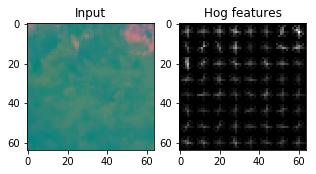

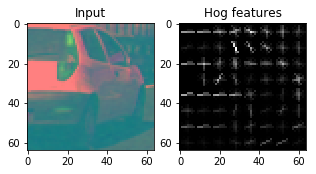

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Also return the hog image if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block), 
        transform_sqrt=True, 
        visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise return only the hog features
    else: 
        features = hog(img, orientations=orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block), 
        transform_sqrt=True, 
        visualise=vis, feature_vector=feature_vec)
        return features  

#Compare the hog features of vehicle and non-vehicle images
feature_images = [X[2], X[10000]]
for image in feature_images:
    hog_features, hog_image = get_hog_features(image[:,:,0], 10, 
                                8, 2, vis=True, feature_vec=True)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))
    ax1.imshow(image)
    ax1.set_title('Input')
    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title('Hog features')
    plt.show() 

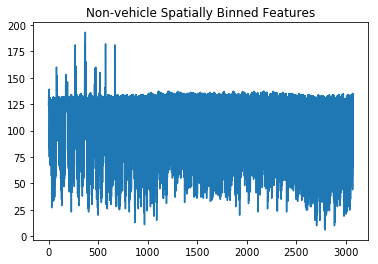

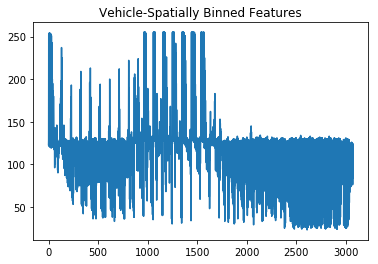

In [4]:
# Define a function to compute binned color features 
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


feature_image = cv2.cvtColor(X[2], cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(feature_image, size=(32, 32))
plt.plot(feature_vec)
plt.title('Non-vehicle Spatially Binned Features')
plt.show()

feature_image = cv2.cvtColor(X[10000], cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(feature_image, size=(32, 32))
plt.plot(feature_vec)
plt.title('Vehicle-Spatially Binned Features')
plt.show()

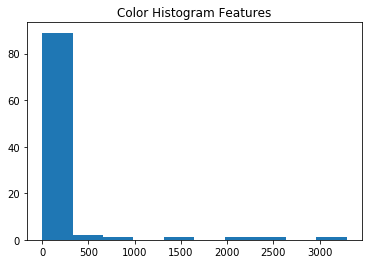

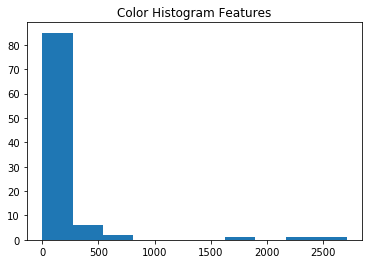

In [5]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

feature_image = X[0]
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hist_features = color_hist(feature_image, nbins=32)
plt.hist(hist_features)
plt.title('Color Histogram Features')
plt.show()

feature_image = X[10000]
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hist_features = color_hist(feature_image, nbins=32)
plt.hist(hist_features)
plt.title('Color Histogram Features')
plt.show()

In [6]:
#Define a function that extract features from an image
def featureExtractor(image):
    _orient = 9 # HOG orientations
    _pix_per_cell = 8 # HOG pixels per cell
    _cell_per_block = 2 # HOG cells per block
    _spatial_size = (32, 32) # Spatial binning dimensions
    _hist_bins = 32 # Number of histogram bins

    hogFeatures_channel_1 = get_hog_features(image[:,:,0], 
                                   orient=_orient, 
                                   pix_per_cell=_pix_per_cell, 
                                   cell_per_block=_cell_per_block, 
                                   vis=False, 
                                   feature_vec=True)
    hogFeatures_channel_2 = get_hog_features(image[:,:,1], 
                                   orient=_orient, 
                                   pix_per_cell=_pix_per_cell, 
                                   cell_per_block=_cell_per_block, 
                                   vis=False, 
                                   feature_vec=True)
    hogFeatures_channel_3 = get_hog_features(image[:,:,2], 
                                   orient=_orient, 
                                   pix_per_cell=_pix_per_cell, 
                                   cell_per_block=_cell_per_block, 
                                   vis=False, 
                                   feature_vec=True)

    binFeatures = bin_spatial(image, size=_spatial_size)
    hist = color_hist(image, nbins=_hist_bins)
    return np.hstack((hogFeatures_channel_1, hogFeatures_channel_2, hogFeatures_channel_3, binFeatures,hist)).ravel()

### Data preprocessing

In [16]:
#Extract features from images
X = np.array([featureExtractor(x) for x in X])
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
#Randomize the data
X, Y = shuffle(scaled_X, Y)
#Split the data into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### Model

In [8]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
# Train
svc.fit(X_train, y_train)
# Accuracy
print('Model accuracy: {:3f}'.format(svc.score(X_test, y_test)))

Model accuracy: 0.992399


In [8]:
import pickle #pickle模块

#Save model
with open('svc_ver1.pickle', 'wb') as f:
    pickle.dump(svc, f)

#Load pre-trained Model
with open('svc_ver1.pickle', 'rb') as f:
    svc = pickle.load(f)

### Search window in different distances
To find out how many sliding window i needed, i observeed where the vehicles appeared in the video. I started this task inside After Effects which is a video editing software, and last i  found 8 window sizes that almost covered all the vehicles, and i used these 8 sliding windows for vehicle detection.
<img src='examples/measurement.png' style='width:1000px;float:left;'>

# Vehicle detector class

In [18]:
from skimage.morphology import label
from scipy.ndimage.measurements import label as lb
from collections import deque
import collections

SlidingWindow_parameters = collections.namedtuple('SlidingWindow', 'startX endX startY endY strideX strideY width height')
vehicle = collections.namedtuple('Vehicle', 'imageLastFrame locationLastFrame boundingBox_Width boundingBox_Height')

class VehicleDetector:
    def __init__(self):
        self.vehicles_detected = []
        self.num_previousVehicles_detected = 0
        self.lk_params = dict( winSize  = (15,15),
                               maxLevel = 2,
                               criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
        
        self.heatmapQue = deque(maxlen = 5)
        self.searchWindows =  [
                                    SlidingWindow_parameters(750, 930, 390, 420, 6, 4, 90, 60), 
                                SlidingWindow_parameters(750, 1180, 400, 420, 10, 6, 100, 65), 
                                SlidingWindow_parameters(850, 980, 390, 410, 13, 7, 135, 75),
                                SlidingWindow_parameters(920, 1020, 395, 415, 16, 8, 165, 85),
                                SlidingWindow_parameters(750, 860, 390, 410, 11, 7, 110, 75),
                                SlidingWindow_parameters(700, 1100, 380, 420, 23, 13, 225, 145),
                                SlidingWindow_parameters(980, 1100, 385, 405, 23, 13, 250, 120),
                                SlidingWindow_parameters(700, 1100, 385, 405, 16, 13, 160, 135),
                                SlidingWindow_parameters(700, 1100, 385, 405, 28, 20, 285, 205)
                              ]
    
    #A sliding window scans an input image from top to bottom and left to right.
    def sliding_window(self, image, x1, x2, y1, y2, stepSizeX, stepSizeY, windowSize):
        # slide a window across the image
        for y in range(y1, y2, stepSizeY):
            for x in range(x1, x2, stepSizeX):
                # yield the current window
                yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
    
    #Draw bounding boxes to represent the vehicles that are detected
    def draw_labeled_bboxes(self, img, labels):
        locations = []
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            if (abs(bbox[0][0] - bbox[1][0]) / abs(bbox[0][1] - bbox[1][1]) > 6) or (abs(bbox[0][1] - bbox[1][1]) / abs(bbox[0][0] - bbox[1][0]) > 6):
                pass
            else:
                locations.append([bbox[0], bbox[1]])
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
                
        return img, locations, [bbox[1][0] - bbox[0][0], bbox[1][1] - bbox[0][1]]
    
    def vehicleDetection(self, image, threshold = 25, threshold2=150, isMainMethod = True):
        ycrcb = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2YCR_CB)
        heatmap = np.zeros(image.shape[:-1])
        #Scan through the input image using different sizes of windows 
        for i, window in enumerate(self.searchWindows):
            for x, y, block in self.sliding_window(ycrcb,
                                              window.startX,
                                              window.endX,
                                              window.startY,
                                              window.endY,
                                              window.strideX,
                                              window.strideY,
                                              (window.width, window.height)):
                
                resized = np.array(cv2.resize(block, (64, 64)))
                features = featureExtractor(resized)
                scaled = X_scaler.transform(features)
                y_pred = svc.predict(np.array([scaled]))[0]
                #If the the patch seems to have vehicles in it, draw on the heatmap on its location
                if y_pred != 0:
                    heatmap[y:y+window.height,x:x+window.width] += 1
        
        heatmap[heatmap < threshold] = 0
        self.heatmapQue.appendleft(heatmap)
        
        #Sum up the heatmaps value in the previous 5 frames
        if len(self.heatmapQue) > 0:
            heatmap_sum  = np.zeros(image.shape[:-1])
            for instance in self.heatmapQue:
                heatmap_sum += instance
        
        heatmap_sum[heatmap_sum < threshold2] = 0
        labels = lb(heatmap_sum)
        
       
        
        if labels[0].max() > 0:
            image, locations, (width, height) = self.draw_labeled_bboxes(image.copy(), labels)
        
            if isMainMethod:
                self.vehicles_detected = []
                for location1, location2 in locations:
                    self.vehicles_detected.append(vehicle(cv2.cvtColor(image.copy(),cv2.COLOR_RGB2GRAY), 
                                                          np.array([[[(location1[0] + location2[0]) / 2, (location1[1] + location2[1]) / 2]]], dtype='float32'),
                                                          width, height))
                self.num_previousVehicles_detected = len(self.vehicles_detected)
                return image
            else:
                return len(locations)
        else:
            if isMainMethod:
                return image
            else:
                return 0


    def tracking(self, imgThisFrame):
        availiable = []            
        for index, current_vehicle in enumerate(self.vehicles_detected):
            gray = cv2.cvtColor(imgThisFrame.copy(), cv2.COLOR_BGR2GRAY)
            p1, st, err = cv2.calcOpticalFlowPyrLK(current_vehicle.imageLastFrame, 
                                                   gray, 
                                                   current_vehicle.locationLastFrame, 
                                                   None, 
                                                   **self.lk_params)
            if st[0][0] == 1:
                cv2.rectangle(imgThisFrame, (int(p1[0][0][0] - current_vehicle.boundingBox_Width //2), int(p1[0][0][1] - current_vehicle.boundingBox_Height//2)), 
                              (int(p1[0][0][0] + current_vehicle.boundingBox_Width //2), int(p1[0][0][1] + current_vehicle.boundingBox_Height//2)), 
                              (0, 0, 255), 3)
                movingForwardY_coef = p1[0][0][1] - current_vehicle.locationLastFrame[0][0][1]
                movingForwardX_coef = p1[0][0][0] - current_vehicle.locationLastFrame[0][0][0]
                dist = np.linalg.norm(p1 - current_vehicle.locationLastFrame)
                availiable.append(vehicle(gray, p1, 
                                          current_vehicle.boundingBox_Width + movingForwardX_coef * 0.15, 
                                          current_vehicle.boundingBox_Height + movingForwardY_coef * 0.3))
                
        if len(availiable) > 0:
            self.vehicles_detected = availiable
            
        else:
            self.vehicles_detected = []
            
        return imgThisFrame
            
    def pipeline(self, image):
        return self.vehicleDetection(image)
#         if len(self.vehicles_detected) > 0:
# #             return self.tracking(image)
#             num_currentVehicle = self.vehicleDetection(image, isMainMethod=False)
#             print(num_currentVehicle, self.num_previousVehicles_detected)
#             if num_currentVehicle == self.num_previousVehicles_detected or num_currentVehicle == 0:
# #                 print('Tracking!')
#                 return self.tracking(image)
#             else:
# #                 print('Number of vehicle detected has changed!', num_currentVehicle, self.num_previousVehicles_detected)
#                 return self.vehicleDetection(image)
#         else:
#             return self.vehicleDetection(image)

## Test

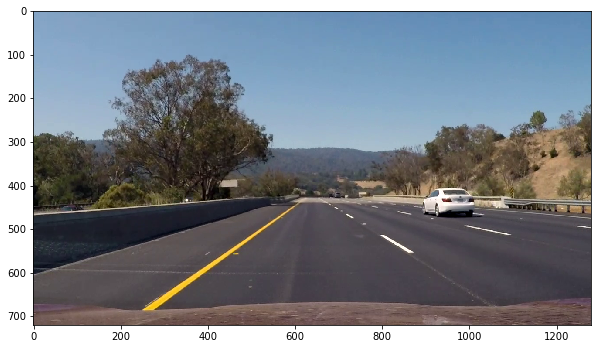

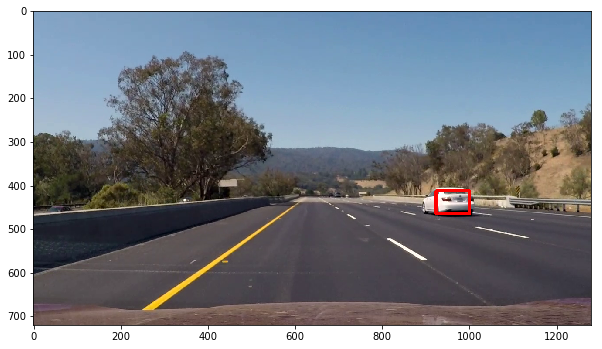

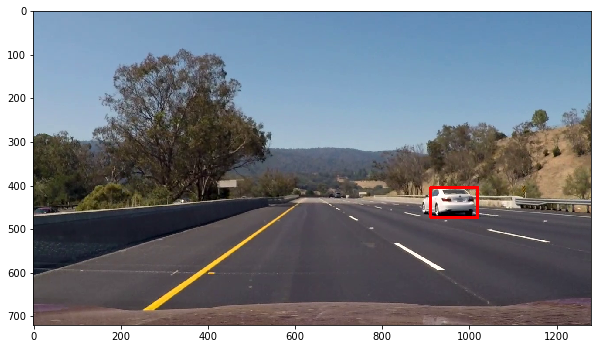

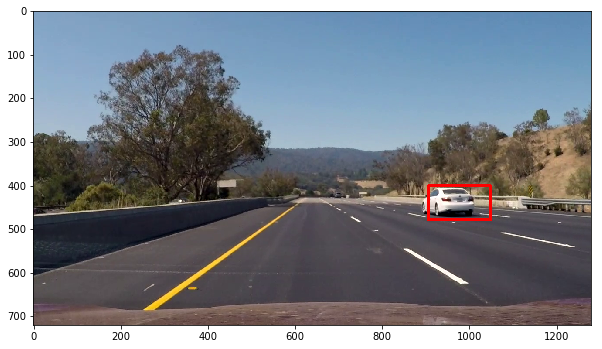

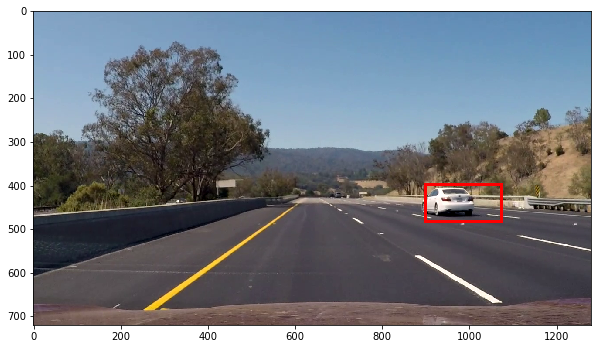

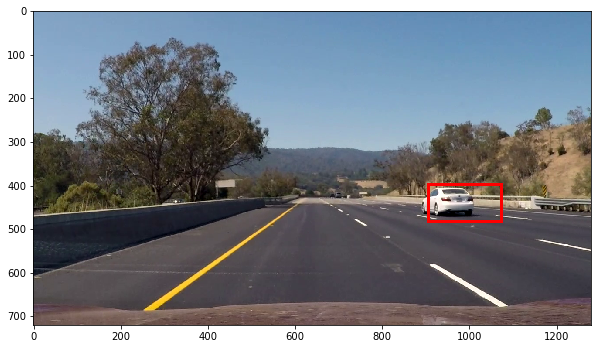

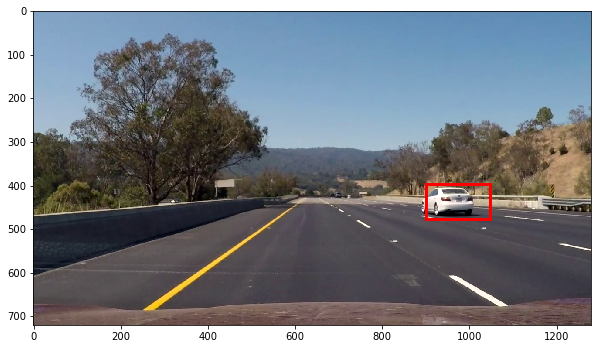

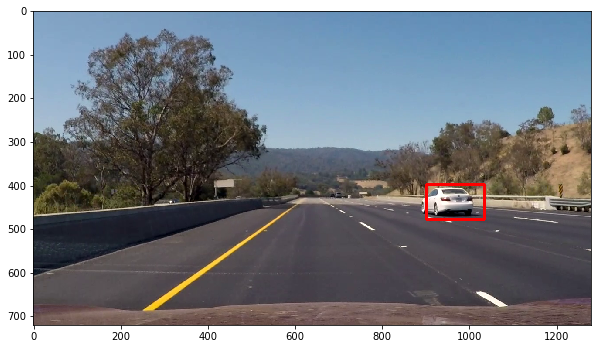

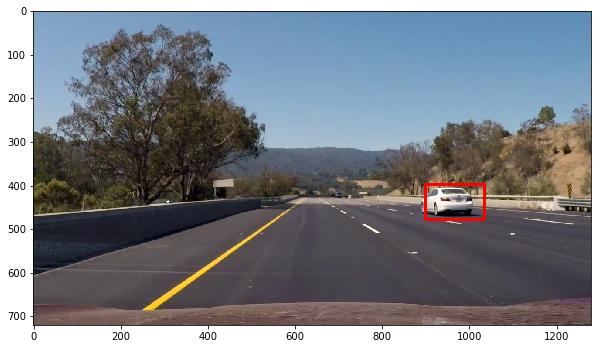

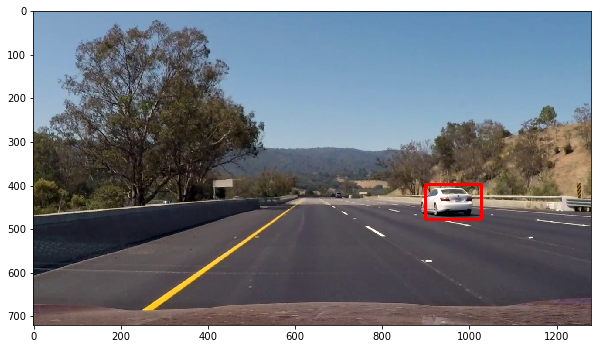

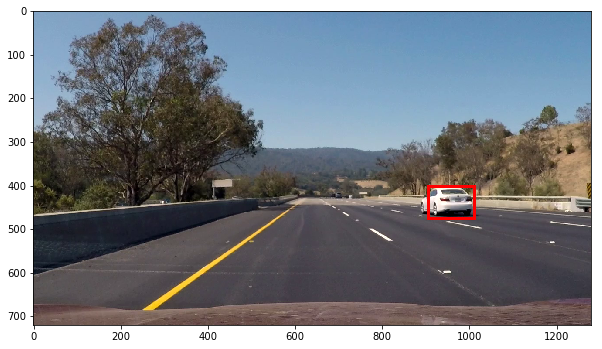

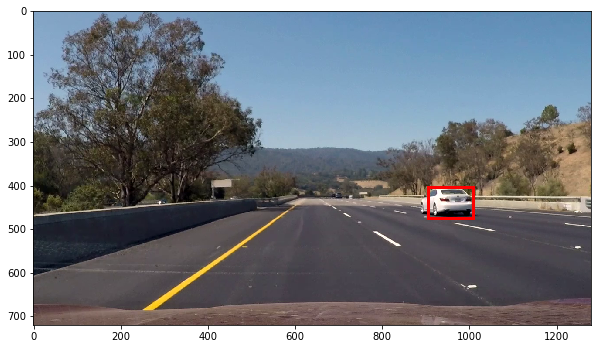

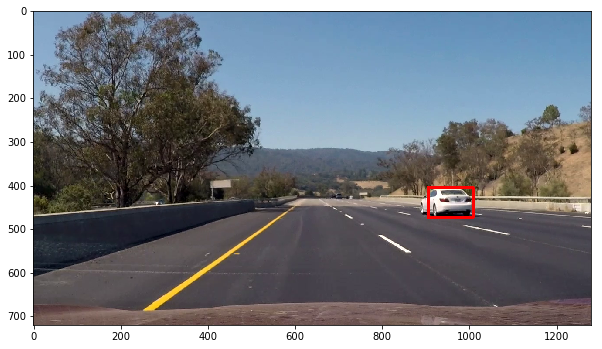

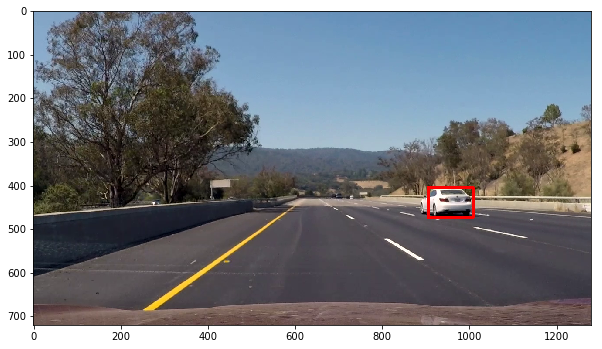

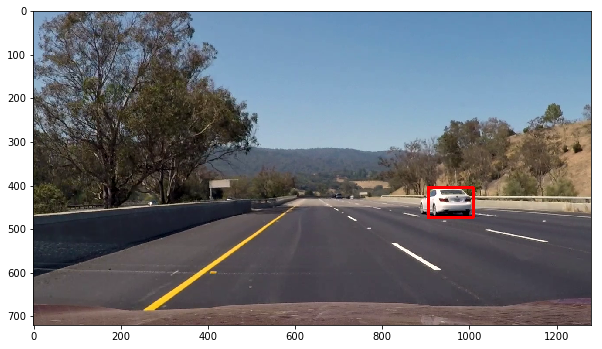

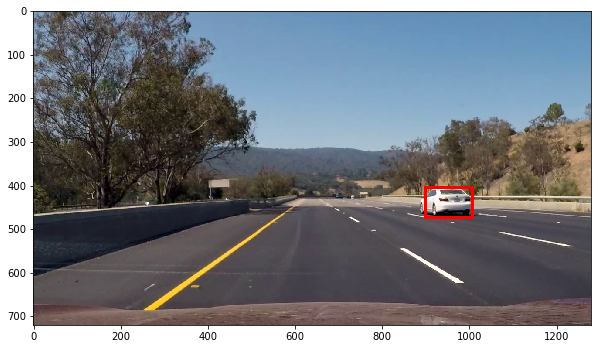

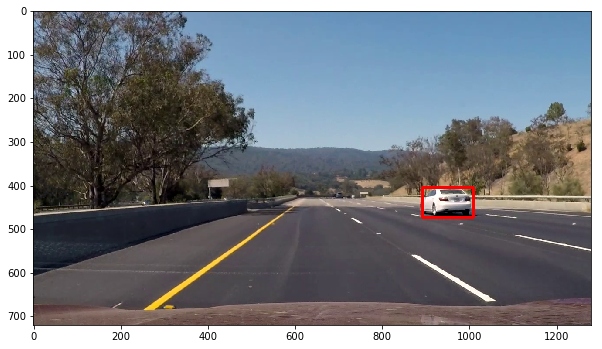

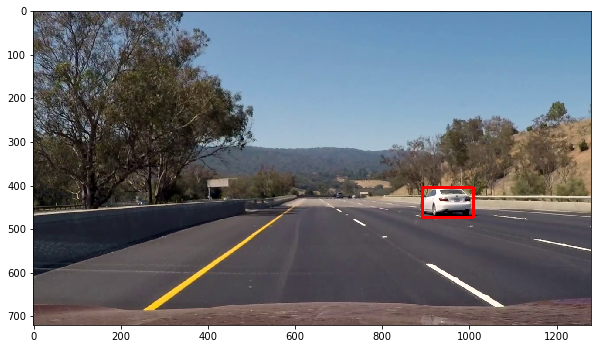

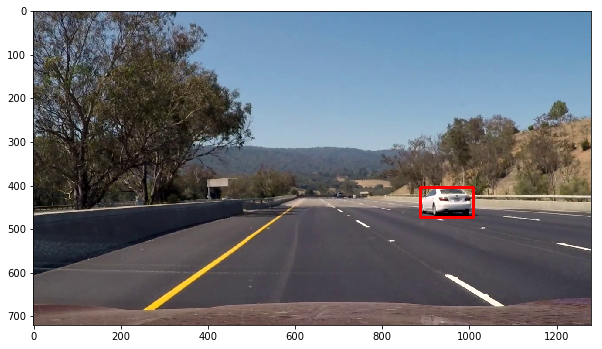

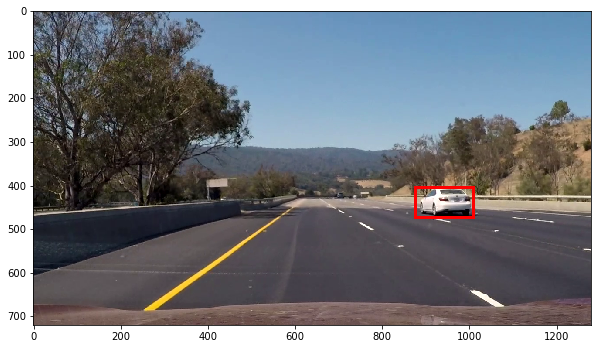

In [ ]:
import matplotlib.pyplot as plt

test = VehicleDetector()


videoReaer = cv2.VideoCapture('project_video.mp4')
counter = 0


while True:
    (ret, frame) = videoReaer.read()
    if counter >= 500 and counter < 520:
        if ret:
            detection = test.pipeline(frame.copy())
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(detection, cv2.COLOR_BGR2RGB))
            plt.show()
        else:
            break
    counter+=1

In [17]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Vehicle detector instance
tracker = VehicleDetector()

# Set up lines for left and right
white_output = 'project_output_v12.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(tracker.pipeline) #NOTE: this function expects color images!!?
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output_v12.mp4
[MoviePy] Writing video project_output_v12.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:04:25<00:03,  3.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_v12.mp4 

Wall time: 1h 4min 25s
